In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.api import Logit, add_constant
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, levene, f_oneway, kruskal
import scikit_posthocs as sp
import altair as alt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
import seaborn as sns
import miceforest as mffrom sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import linregress


In [ ]:
CSV_PATH = 'output/uber_rides_enriched.csv'

In [ ]:
df = pd.read_csv(
        CSV_PATH,
        parse_dates=['start_at','end_at','arrived_at','time_grid'],
    )

# Localizamos las fechas en la zona horaria de Lima
for col in ['start_at', 'end_at', 'arrived_at', 'time_grid']:
    df[col] = df[col].dt.tz_localize(
        'America/Lima',
        ambiguous='NaT',
        nonexistent='shift_forward'
    )

In [ ]:
df.drop(
    columns=[
        'duration',
        'distance',
        'price_distance',
        'price_duration',
        'cost',
        'cost_distance',
        'cost_duration',
    ],
    inplace=True
)

In [ ]:
# Filas con coordenadas nulas y end_state == 'drop off'
mask = (
    df['start_lat'].isna() &
    (df['end_state'] == 'drop off')
)

# Cuántas filas son
print(f"Se eliminan {mask.sum()} ({mask.sum()/len(df):.2%}) filas de un total de {len(df)}")

# Eliminar esas filas
df = df.loc[~mask].copy()

Se eliminan 533 (2.31%) filas de un total de 23111


In [ ]:
df_drop = df[
    df.end_state == 'drop off'
].copy()

df_n = df[
    ~(df.end_state == 'drop off')
].drop(
    columns=[
        'end_lat',
        'end_lon',
        'arrived_at',
        'driver_score',
        'rider_score',
        'dist_start_to_end_m',
        'time_start_to_end_s',
    ]
).copy()

In [ ]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16884 entries, 0 to 23108
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype                       
---  ------                  --------------  -----                       
 0   user_id                 16884 non-null  object                      
 1   driver_id               16884 non-null  object                      
 2   icon                    16884 non-null  object                      
 3   start_type              16884 non-null  object                      
 4   start_at                16884 non-null  datetime64[ns, America/Lima]
 5   start_lat               16884 non-null  float64                     
 6   start_lon               16884 non-null  float64                     
 7   end_at                  16880 non-null  datetime64[ns, America/Lima]
 8   end_lat                 16884 non-null  float64                     
 9   end_lon                 16884 non-null  float64                     
 10  end

In [259]:
# ------------------------------------------------------------
# (2) Calcular wait_calc (clip a 0) y trip_calc (sin clip)
# ------------------------------------------------------------
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
)

# ------------------------------------------------------------
# (3) Calcular velocidades y banderas de inconsistencias graves
# ------------------------------------------------------------
VEL_MIN = 5       # km/h mínimo plausible
VEL_MAX = 150     # km/h máximo plausible
DIST_UMBRAL = 50  # metros: umbral para “distancia significativa”

# TRIP
df_drop['speed_real_trip_kmh'] = (
    df_drop['dist_start_to_end_m'] / df_drop['trip_calc']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['speed_api_trip_kmh'] = (
    df_drop['dist_start_to_end_m'] / df_drop['time_start_to_end_s']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['flag_inconsistencia_grave_trip'] = (
    (df_drop['speed_real_trip_kmh'] < VEL_MIN) |
    (df_drop['speed_real_trip_kmh'] > VEL_MAX) |
    (df_drop['trip_calc'] < 0) |
    ((df_drop['trip_calc'] == 0) & (df_drop['dist_start_to_end_m'] >= DIST_UMBRAL))
)

# WAIT (sin cambios en la lógica de inconsistencias graves)
df_drop['speed_real_wait_kmh'] = (
    df_drop['dist_driver_to_start_m'] / df_drop['wait_calc']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['speed_api_wait_kmh'] = (
    df_drop['dist_driver_to_start_m'] / df_drop['time_driver_to_start_s']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['flag_inconsistencia_grave_wait'] = (
    (df_drop['speed_real_wait_kmh'] < VEL_MIN) |
    (df_drop['speed_real_wait_kmh'] > VEL_MAX) |
    ((df_drop['wait_calc'] == 0) & (df_drop['dist_driver_to_start_m'] >= DIST_UMBRAL))
)

# ------------------------------------------------------------
# (4) Definir factores de corrección
# ------------------------------------------------------------
factor_trip = 2.0   # ×200 % para TRIP
factor_wait = 3.5   # ×350 % para WAIT

df_drop['api_time_corr_trip'] = df_drop['time_start_to_end_s'] * factor_trip
df_drop['api_time_corr_wait'] = df_drop['time_driver_to_start_s'] * factor_wait

# ------------------------------------------------------------
# (5) Calcular errores absolutos y relativos corregidos
# ------------------------------------------------------------
df_drop['error_abs_trip']      = (df_drop['trip_calc'] - df_drop['time_start_to_end_s']).abs()
df_drop['error_rel_corr_trip'] = (
    (df_drop['trip_calc'] - df_drop['api_time_corr_trip']).abs() /
    df_drop['api_time_corr_trip'].replace({0: np.nan})
)

df_drop['error_abs_wait']      = (df_drop['wait_calc'] - df_drop['time_driver_to_start_s']).abs()
df_drop['error_rel_corr_wait'] = (
    (df_drop['wait_calc'] - df_drop['api_time_corr_wait']).abs() /
    df_drop['api_time_corr_wait'].replace({0: np.nan})
)

# ------------------------------------------------------------
# (6) Construir subconjuntos "válidos" usando dropna temporal
# ------------------------------------------------------------
df_trip_valid = df_drop.dropna(subset=['trip_calc']).loc[
    (df_drop['time_start_to_end_s'] > 0) &
    (~df_drop['flag_inconsistencia_grave_trip']) &
    (df_drop['error_rel_corr_trip'] < 20)
].copy()

df_wait_valid = df_drop.dropna(subset=['wait_calc']).loc[
    (df_drop['time_driver_to_start_s'] > 0) &
    (~df_drop['flag_inconsistencia_grave_wait']) &
    (df_drop['error_rel_corr_wait'] < 50)
].copy()

# ------------------------------------------------------------
# (7) Calcular umbrales globales de percentil 95 (P95) para TRIP y WAIT
# ------------------------------------------------------------
ABS_THRESH_TRIP  = df_trip_valid['error_abs_trip'].quantile(0.95)
REL_THRESH_TRIP  = df_trip_valid['error_rel_corr_trip'].quantile(0.95)
SMALL_TIME_TRIP  = 60   # usar relativo si api_time ≥ 60 s

ABS_THRESH_WAIT  = df_wait_valid['error_abs_wait'].quantile(0.95)
REL_THRESH_WAIT  = df_wait_valid['error_rel_corr_wait'].quantile(0.95)
SMALL_TIME_WAIT  = 60   # usar relativo si api_time ≥ 60 s

# ------------------------------------------------------------
# (8) Definir umbrales dinámicos contínuos para TRIP
#    (ahora con base estadística empírica y función no lineal)
# ------------------------------------------------------------
def obtener_umbrales_trip(api_time_s):
    """
    Umbrales continuos para TRIP, basados en ajustes de regresión cuantílica
    y heteroscedasticidad estimada:

      1) abs_b = c * (api_time_s ** b), con c=0.247, b=0.9
      2) rel_b = L + (U - L) / [1 + exp(alpha * (api_time_s - beta))],
         con U=1.0, L=0.3, alpha=0.002, beta=600
      3) sm_b = 200  (no aplicar relativo si api_time_s < 200 s)
    """
    c = 0.247
    b = 0.9
    abs_b = c * (api_time_s ** b)

    U = 1.0
    L = 0.3
    alpha = 0.002
    beta = 600.0
    rel_b = L + (U - L) / (1 + np.exp(alpha * (api_time_s - beta)))

    sm_b = 200  # segundos

    return abs_b, rel_b, sm_b

# ------------------------------------------------------------
# (9) Preparar mediana de wait_calc por hora para filas sin coords
# ------------------------------------------------------------
df_drop['hour'] = df_drop['start_at'].dt.hour
mediana_por_hora = (
    df_drop.loc[df_drop['arrived_at'].notna()]
           .groupby('hour')['wait_calc']
           .median()
           .rename('mediana_wait_por_hora')
)

T_MAX  = 7200   # 2 horas en segundos: umbral absoluto si faltan coords
FACTOR = 3      # factor relativo sobre mediana por hora si faltan coords

# ------------------------------------------------------------
# (10) Definir funciones de detección de discrepancias
# ------------------------------------------------------------
def detectar_discrepancia_trip(row):
    """
    Detecta discrepancias en TRIP con una banda permisiva del 20 %:
      • No marca si trip_calc ∈ [0.8×api_time, api_time].
      • Si trip_calc < 0.8×api_time, aplica umbrales continuos (abs_b, rel_b, sm_b).
      • Mantiene chequeos globales de percentil 95 y de inconsistencias graves.
    """
    dist     = row['dist_start_to_end_m']
    api_time = row['time_start_to_end_s']
    trip     = row['trip_calc']
    hour     = row['hour']

    # --- Caso A: faltan coords de TRIP ---
    if pd.isna(dist) or pd.isna(api_time):
        if pd.notna(trip) and trip > T_MAX:
            return True
        if pd.notna(trip):
            umbral_hora = (mediana_por_hora.loc[hour]
                           if hour in mediana_por_hora.index
                           else mediana_por_hora.median()) * FACTOR
            if trip > umbral_hora:
                return True
        return False

    # --- Caso B: hay coords ---
    # (1) Inconsistencia grave (vel fuera de rango)
    if row['flag_inconsistencia_grave_trip']:
        return True

    # (2) api_time = 0 y distancia significativa
    if api_time == 0 and dist >= DIST_UMBRAL:
        return True

    # (3) Relativo global (P95) si trip_calc < api_time_corr_trip y api_time ≥ 60 s
    if api_time >= SMALL_TIME_TRIP and trip < row['api_time_corr_trip']:
        rel_corr = abs(trip - row['api_time_corr_trip']) / row['api_time_corr_trip']
        if rel_corr > REL_THRESH_TRIP:
            return True

    # (4) Si trip_calc < 0.8×api_time, aplicar umbrales continuos; 
    #     si trip_calc ∈ [0.8×api_time, api_time], NO marcar discrepancia
    if trip < api_time * 0.8:
        abs_b, rel_b, sm_b = obtener_umbrales_trip(api_time)
        # (4a) Umbral absoluto continuo
        if (api_time - trip) > abs_b:
            return True
        # (4b) Umbral relativo sigmoidal
        if api_time >= sm_b and trip < row['api_time_corr_trip']:
            rel_corr_b = abs(trip - row['api_time_corr_trip']) / row['api_time_corr_trip']
            if rel_corr_b > rel_b:
                return True

    return False


def detectar_discrepancia_wait(row):
    """
    Detecta discrepancias en WAIT de forma simétrica:
      • No marca si wait_calc ∈ [0.8×api_time, api_time].
      • Si wait_calc < 0.8×api_time, aplicar umbrales continuos (abs_b, rel_b, sm_b).
      • Mantiene chequeos globales de percentil 95 y de inconsistencias graves.
    """
    dist     = row['dist_driver_to_start_m']
    api_time = row['time_driver_to_start_s']
    wait     = row['wait_calc']
    hour     = row['hour']

    # --- Caso A: faltan coords de WAIT ---
    if pd.isna(dist) or pd.isna(api_time):
        if pd.notna(wait) and wait > T_MAX:
            return True
        if pd.notna(wait):
            umbral_hora = (mediana_por_hora.loc[hour]
                           if hour in mediana_por_hora.index
                           else mediana_por_hora.median()) * FACTOR
            if wait > umbral_hora:
                return True
        return False

    # --- Caso B: hay coords ---
    if row['flag_inconsistencia_grave_wait']:
        return True
    if api_time == 0 and dist >= DIST_UMBRAL:
        return True

    # (3) Relativo global (P95) si wait_calc < api_time_corr_wait y api_time ≥ 60 s
    if api_time >= SMALL_TIME_WAIT and wait < row['api_time_corr_wait']:
        rel_corr = abs(wait - row['api_time_corr_wait']) / row['api_time_corr_wait']
        if rel_corr > REL_THRESH_WAIT:
            return True

    # (4) Si wait_calc < 0.8×api_time, aplicar umbrales continuos
    if wait < api_time * 0.8:
        abs_b, rel_b, sm_b = obtener_umbrales_trip(api_time)
        # Umbral absoluto continuo
        if (api_time - wait) > abs_b:
            return True
        # Umbral relativo sigmoidal
        if api_time >= sm_b:
            rel_corr_b = abs(wait - row['api_time_corr_wait']) / row['api_time_corr_wait']
            if rel_corr_b > rel_b:
                return True

    return False

# ------------------------------------------------------------
# (11) Aplicar la detección de discrepancias a todo df_drop
# ------------------------------------------------------------
df_drop['flag_discrepancia_trip'] = df_drop.apply(detectar_discrepancia_trip, axis=1)
df_drop['flag_discrepancia_wait'] = df_drop.apply(detectar_discrepancia_wait, axis=1)

# ------------------------------------------------------------
# (12) Contar resultados finales
# ------------------------------------------------------------
n_total     = len(df_drop)
n_disc_trip = df_drop['flag_discrepancia_trip'].sum()
n_disc_wait = df_drop['flag_discrepancia_wait'].sum()

print(f"Total de filas en df_drop:                {n_total}")
print(f"Viajes TRIP marcados como discrepancia:   {n_disc_trip} ({n_disc_trip / n_total:.2%})")
print(f"Viajes WAIT marcados como discrepancia:   {n_disc_wait} ({n_disc_wait / n_total:.2%})\n")

print(" Estadísticas error_rel_corr_trip:\n", df_drop['error_rel_corr_trip'].describe(), "\n")
print(" Estadísticas error_rel_corr_wait:\n", df_drop['error_rel_corr_wait'].describe(), "\n")

# ------------------------------------------------------------
# (13) Eliminar columna auxiliar 'hour' si ya no se necesita
# ------------------------------------------------------------
df_drop.drop(columns=['hour'], inplace=True)


Total de filas en df_drop:                16884
Viajes TRIP marcados como discrepancia:   3591 (21.27%)
Viajes WAIT marcados como discrepancia:   9137 (54.12%)

 Estadísticas error_rel_corr_trip:
 count    16880.000000
mean         0.619371
std          1.523551
min          0.000000
25%          0.219215
50%          0.404311
75%          0.595745
max         55.395760
Name: error_rel_corr_trip, dtype: float64 

 Estadísticas error_rel_corr_wait:
 count    15183.000000
mean         0.949415
std          3.760104
min          0.000000
25%          0.610390
50%          0.781851
75%          1.000000
max        273.285714
Name: error_rel_corr_wait, dtype: float64 



In [260]:
# 1) Anular arrived_at en las filas donde flag_discrepancia_wait == True
df_drop.loc[df_drop['flag_discrepancia_wait'], 'arrived_at'] = pd.NaT

# 2) Anular end_at en las filas donde flag_discrepancia_trip == True
df_drop.loc[df_drop['flag_discrepancia_trip'], 'end_at'] = pd.NaT

# 3) Verificar cuántas filas quedaron anuladas
n_arrived_nulos = df_drop['arrived_at'].isna().sum()
n_end_nulos     = df_drop['end_at'].isna().sum()
print(f"Arrived_at anuladas (total NaT en arrived_at): {n_arrived_nulos}")
print(f"End_at anuladas     (total NaT en end_at):     {n_end_nulos}")

# 3) Imputar 'arrived_at' directo desde la API:
mask_arrived_nulos = df_drop['arrived_at'].isna()
df_drop.loc[mask_arrived_nulos, 'arrived_at'] = (
    df_drop.loc[mask_arrived_nulos, 'start_at']
    + pd.to_timedelta(df_drop.loc[mask_arrived_nulos, 'time_driver_to_start_s'], unit='s')
)

#    Para filas en que imputamos arrived_at pero NO tenían discrepancia TRIP,
#    end_at quedó “antiguo” y causaría trip_calc erróneo.
mask_arrived_imputada = mask_arrived_nulos
mask_trip_no_disc    = ~df_drop['flag_discrepancia_trip']
mask_corregir_trip   = mask_arrived_imputada & mask_trip_no_disc

df_drop.loc[mask_corregir_trip, 'end_at'] = pd.NaT

# 6) Recalcular 'trip_start' basado en el arrived_at corregido
df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)

df_drop.loc[mask_corregir_trip, 'end_at'] = (
    df_drop.loc[mask_corregir_trip, 'trip_start']
    + pd.to_timedelta(df_drop.loc[mask_corregir_trip, 'trip_calc'], unit='s')
)

# 5) Imputar 'end_at' directo desde la API:
mask_end_nulos = df_drop['end_at'].isna()
df_drop.loc[mask_end_nulos, 'end_at'] = (
    df_drop.loc[mask_end_nulos, 'trip_start']
    + pd.to_timedelta(df_drop.loc[mask_end_nulos, 'time_start_to_end_s'], unit='s')
)

# 6) Recalcular 'wait_calc' y 'trip_calc' a partir de los timestamps completos
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
    .clip(lower=0)
)

# 7) Verificación final de que ya no haya NaN/NaT en wait_calc/trip_calc
print("Nulos después de imputación:")
print("   arrived_at NaT:", df_drop['arrived_at'].isna().sum())
print("   end_at     NaT:", df_drop['end_at'].isna().sum())
print("   wait_calc  NaN:", df_drop['wait_calc'].isna().sum())
print("   trip_calc  NaN:", df_drop['trip_calc'].isna().sum())


Arrived_at anuladas (total NaT en arrived_at): 9138
End_at anuladas     (total NaT en end_at):     3595
Nulos después de imputación:
   arrived_at NaT: 156
   end_at     NaT: 0
   wait_calc  NaN: 156
   trip_calc  NaN: 0


In [261]:
mask_arrived_faltante = df_drop['arrived_at'].isna()
n_faltantes = mask_arrived_faltante.sum()
print(f"Filas con arrived_at NaT tras imputación previa: {n_faltantes}")

# ------------------------------------------------------------
# (4) Calcular la mediana global de wait_calc entre las filas válidas
# ------------------------------------------------------------
mediana_global = df_drop.loc[df_drop['arrived_at'].notna(), 'wait_calc'].median()
print(f"Mediana global de wait_calc (filas con arrived_at válido): {mediana_global:.2f} s")

# ------------------------------------------------------------
# (5) Imputar wait_calc = mediana_global en las filas faltantes
# ------------------------------------------------------------
df_drop.loc[mask_arrived_faltante, 'wait_calc'] = mediana_global

# ------------------------------------------------------------
# (6) Reconstruir arrived_at para esas filas
# ------------------------------------------------------------
df_drop.loc[mask_arrived_faltante, 'arrived_at'] = (
    df_drop.loc[mask_arrived_faltante, 'start_at']
    + pd.to_timedelta(df_drop.loc[mask_arrived_faltante, 'wait_calc'], unit='s')
)

# ------------------------------------------------------------
# (7) Recalcular wait_calc y trip_calc en todo el DataFrame
# ------------------------------------------------------------
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
    .clip(lower=0)
)

# ------------------------------------------------------------
# (8) Verificación final: no debería quedar ningún NaN/NaT en arrived_at, wait_calc ni trip_calc
# ------------------------------------------------------------
print("\n>> Nulos después de la imputación con mediana global:")
print("   arrived_at NaT:", df_drop['arrived_at'].isna().sum())
print("   wait_calc  NaN:", df_drop['wait_calc'].isna().sum())
print("   trip_calc  NaN:", df_drop['trip_calc'].isna().sum())

Filas con arrived_at NaT tras imputación previa: 156
Mediana global de wait_calc (filas con arrived_at válido): 540.00 s

>> Nulos después de la imputación con mediana global:
   arrived_at NaT: 0
   wait_calc  NaN: 0
   trip_calc  NaN: 0


In [262]:
aux_columns = [
    'trip_start',
    'speed_real_trip_kmh',
    'speed_api_trip_kmh',
    'flag_inconsistencia_grave_trip',
    'speed_real_wait_kmh',
    'speed_api_wait_kmh',
    'flag_inconsistencia_grave_wait',
    'api_time_corr_trip',
    'api_time_corr_wait',
    'error_abs_trip',
    'error_rel_corr_trip',
    'error_abs_wait',
    'error_rel_corr_wait',
    'flag_discrepancia_trip',
    'flag_discrepancia_wait'
]

df_drop.drop(columns=aux_columns, inplace=True)

In [ ]:
def outliers(
    df : pd.DataFrame,
    col : str,
    rango : range = range(0,101),
    intervalo : int = 1000
) :
    '''
    Genera un gráfico interactivo de línea que muestra el valor de cada percentil
    de la columna especificada.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada; se eliminan filas con valores NaN en `start_lat`.
    col : str
        Nombre de la columna de la que calcular los percentiles.
    rango : range, opcional
        Rango de percentiles a evaluar (por defecto 0-100).
    intervalo : int, opcional
        Número de divisiones usadas para calcular los quantiles (por defecto 1000).

    Devuelve
    -------
    alt.Chart
        Gráfico Altair interactivo con percentil (eje x) vs. valor (eje y).
    '''
    df = df.dropna(subset=col)
    resultados = []
    
    for i in rango:
        valor = df[col].quantile(i / intervalo)
        resultados.append(
            {
                'p' : i/(intervalo/100),
                'valor' : valor
            }
        )

    df_res = pd.DataFrame(resultados)

    chart = (
        alt.Chart(df_res, width=700, height=400)
        .mark_line(point=True)
        .encode(
            x=alt.X('p:Q', title='Percentil (p)'),
            y=alt.Y('valor:Q', title=col),
            tooltip=[
                alt.Tooltip('p:Q', format='.1f', title='p'),
                alt.Tooltip('valor:Q', format='.2f', title=col)
            ]
        )
        .interactive()
    )

    return chart

In [ ]:
outliers(
    df_drop,
    col='price',
    rango=range(0,101),
    intervalo=100
)

alt.Chart(...)

In [ ]:
df_drop.loc[(df_drop.price < 1700) | (df_drop.price > 14953.52), 'price'] = np.nan

In [266]:
df_drop['hour'] = df_drop['start_at'].dt.hour
df_drop['weekday'] = df_drop['start_at'].dt.weekday      # 0=Lunes … 6=Domingo
df_drop['weekday_name'] = df_drop['start_at'].dt.day_name()

In [ ]:
# 1) Candidate variables
candidates = [
    'dist_start_to_end_m',
    'dist_driver_to_start_m',
    'trip_calc',
    'wait_calc',
    'hour'
]

# 2) Prepare DataFrame for modeling
df_mod = df_drop.dropna(subset=['price'] + candidates).copy()
y = df_mod['price']
X = df_mod[candidates]

# 3) Iterative VIF filtering (drop VIF > 10)
X_const = sm.add_constant(X)
while True:
    vif = pd.Series(
        [variance_inflation_factor(X_const.values, i)
         for i in range(X_const.shape[1])],
        index=X_const.columns
    ).drop('const')
    max_vif = vif.max()
    if max_vif <= 10:
        break
    drop_var = vif.idxmax()
    print(f"Dropping '{drop_var}' due to high VIF ({max_vif:.1f})")
    X = X.drop(columns=[drop_var])
    X_const = sm.add_constant(X)

print("Variables after VIF filtering:", list(X.columns))

# 4) Initial robust fit (HC3)
model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary())

# 5) Drop non-significant predictors (p > 0.05)
pvals = pd.Series(model.pvalues, index=X_const.columns)
insig = pvals[pvals > 0.05].drop('const', errors='ignore').index.tolist()
if insig:
    print("Dropping non-significant predictors:", insig)
    X = X.drop(columns=insig)
    X_const = sm.add_constant(X)
else:
    print("All predictors significant at 5%")

# 6) Final robust fit
final = sm.OLS(y, X_const).fit(cov_type='HC3')
print(final.summary())

# 7) Influence diagnostics
infl = OLSInfluence(final)
df_mod['std_resid'] = infl.resid_studentized_internal
df_mod['cooks_d']   = infl.cooks_distance[0]
df_mod['leverage']  = infl.hat_matrix_diag

# 8) outlier flags
n = len(df_mod)
df_mod['outlier'] = (
    df_mod['std_resid'].abs() > 3
) | (
    df_mod['cooks_d'] > (4/n)
) | (
    df_mod['leverage'] > 2*(len(X_const))/n
)
print(f"outliers: {df_mod['outlier'].sum()} of {n}")

Variables after VIF filtering: ['dist_start_to_end_m', 'dist_driver_to_start_m', 'trip_calc', 'wait_calc', 'hour']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1605.
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        19:16:52   Log-Likelihood:            -1.3926e+05
No. Observations:               15849   AIC:                         2.785e+05
Df Residuals:                   15843   BIC:                         2.786e+05
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----

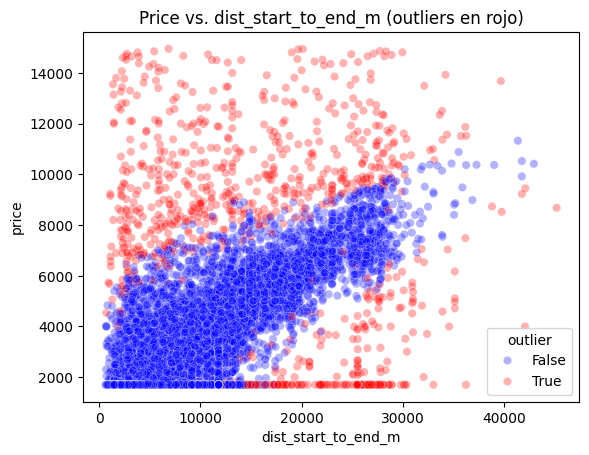

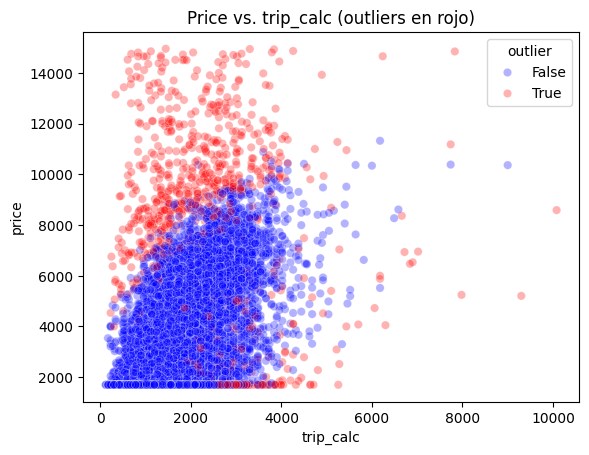

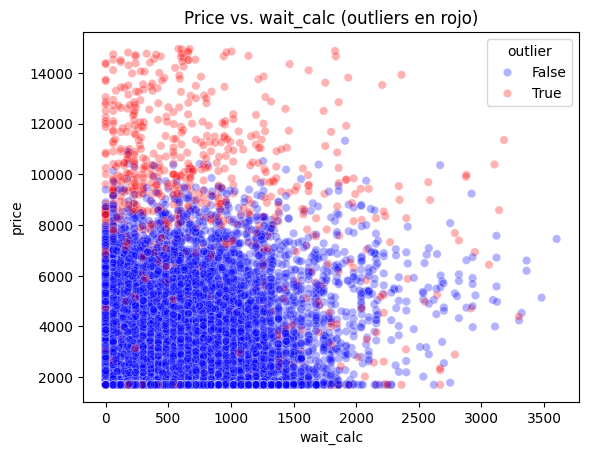

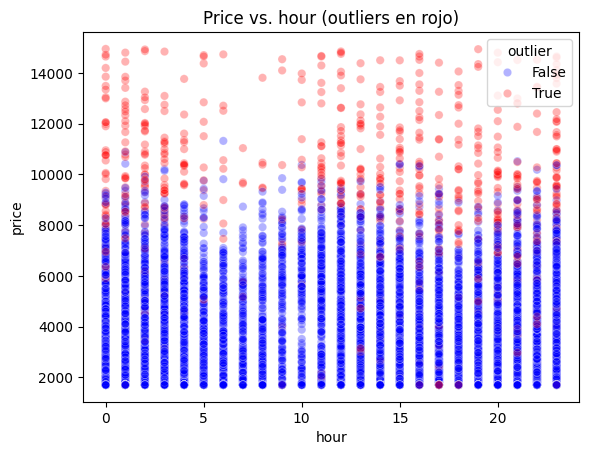

In [ ]:
for var in X.columns :
    sns.scatterplot(
        data=df_mod, x=var, y='price',
        hue='outlier', palette={False:'blue',True:'red'}, alpha=0.3
    )
    plt.title(f'Price vs. {var} (outliers en rojo)')
    plt.show()


In [ ]:
df_drop = df_drop.merge(
    df_mod[['outlier']],
    how='left',
    left_index=True,
    right_index=True
)

df_drop.loc[df_drop['outlier'] == True, 'price'] = np.nan
df_drop.drop(
    columns=['outlier'],
    inplace=True
)

In [ ]:
# 1) Variables significativas para imputar precio
sig_vars = X.columns

# 2) Preparamos DataFrame con esas variables + price
cols = sig_vars.to_list() + ['price']
df_price = df_drop[cols].copy().reset_index()

# 4) Crear el kernel de imputación con miceforest
kernel = mf.ImputationKernel(
    data         = df_price,
    random_state = 0
)

# 5) Ejecutar MICE por 5 iteraciones (puedes aumentar si quieres mayor convergencia)
kernel.mice(iterations=50)

# 6) Recuperar el dataset imputado
imputed_df = kernel.complete_data(dataset=0)

# 7) Reportar
print(f"Se imputaron {df_drop.price.isna().sum()} valores de 'price' usando miceforest")


Se imputaron 1238 valores de 'price' usando miceforest


In [68]:
cuantitativas = ['price','dist_driver_to_start_m','time_driver_to_start_s','dist_start_to_end_m','time_start_to_end_s','wait_calc','trip_calc','d2m','t2m','u10','v10','tcc','tp']
cualitativas = ['icon','start_type','end_state','source','driver_score','rider_score','hour','weekday']

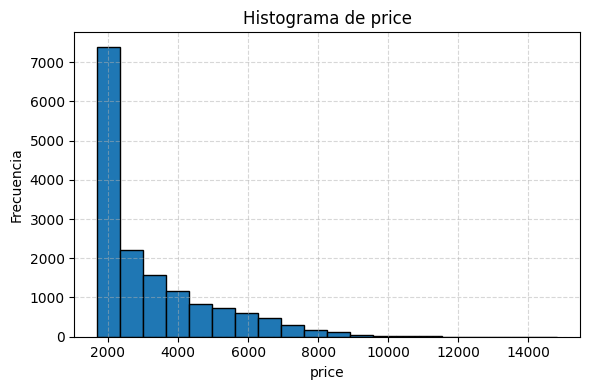

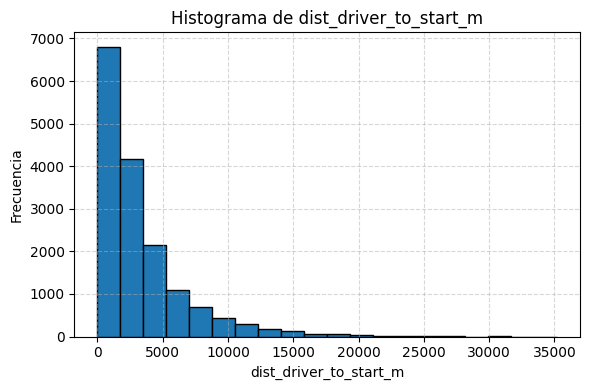

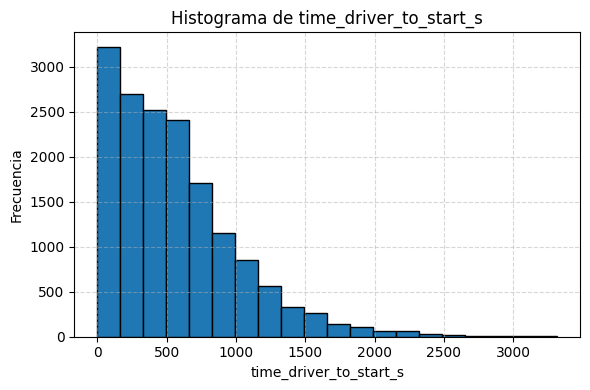

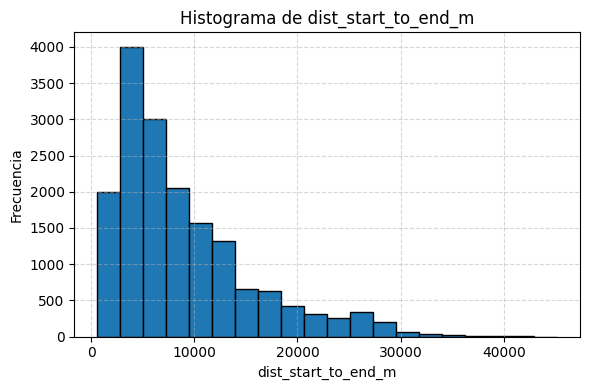

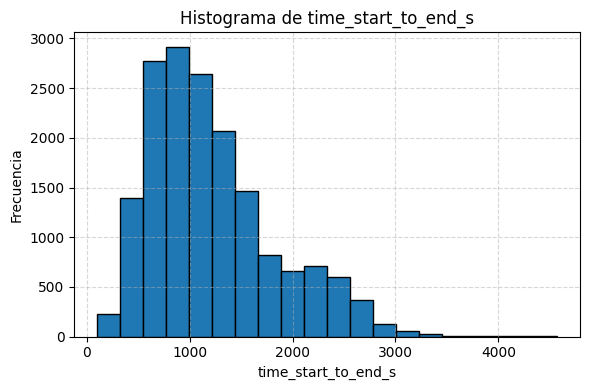

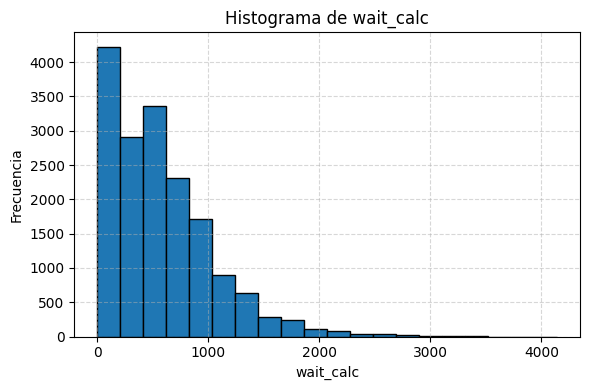

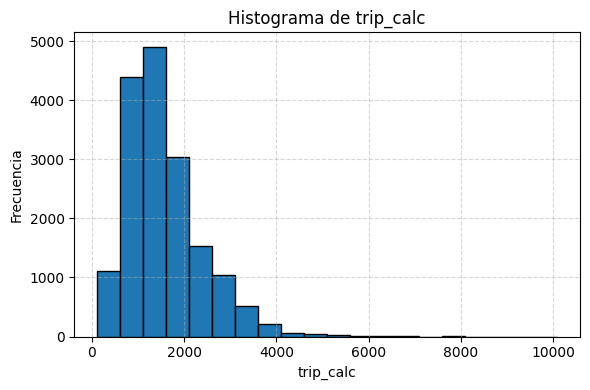

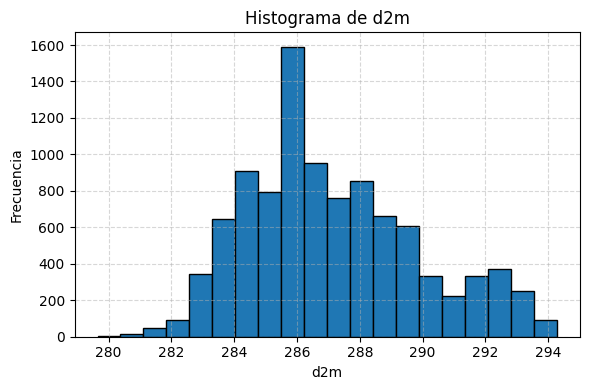

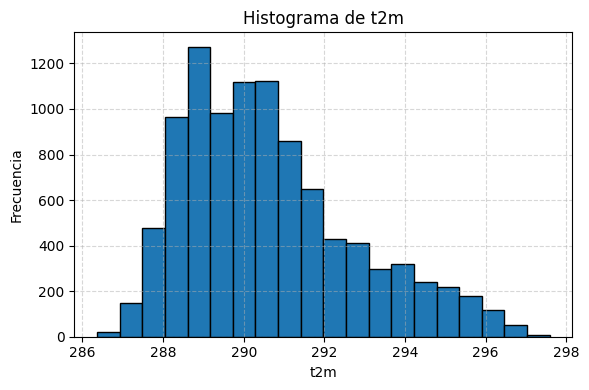

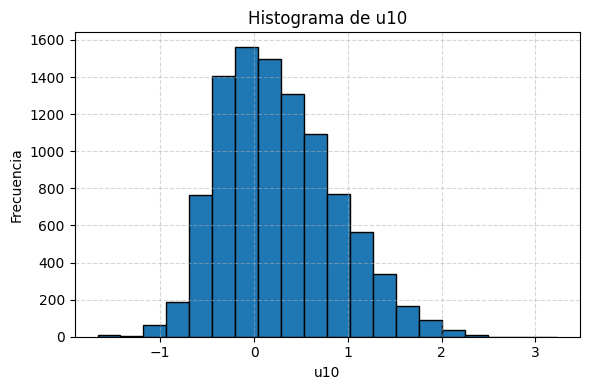

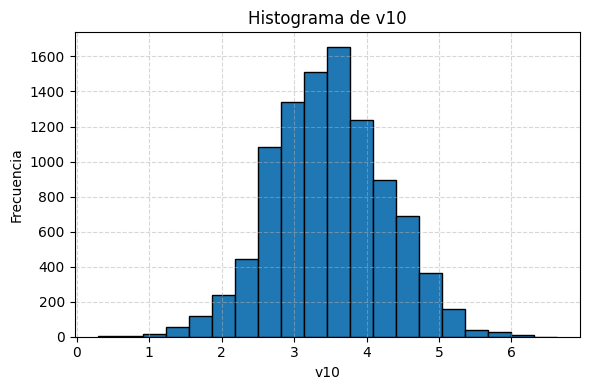

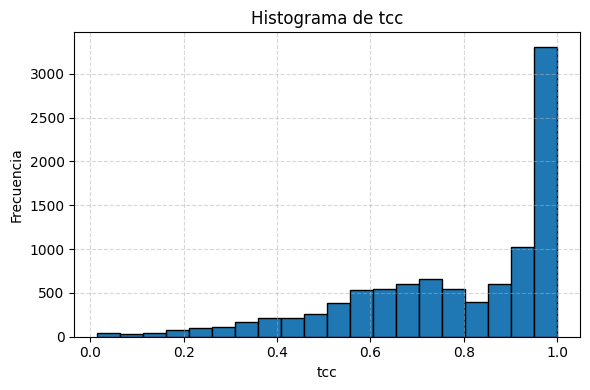

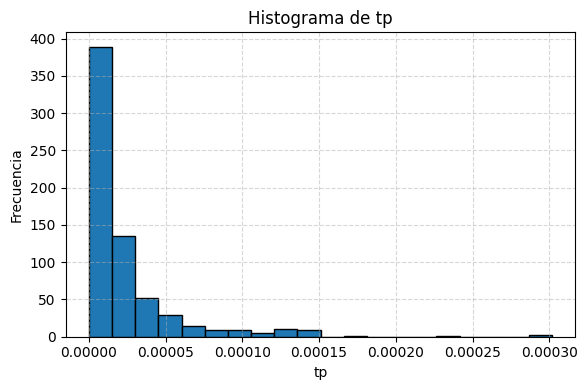

In [69]:
for col in cuantitativas:
    plt.figure(figsize=(6, 4))
    df_drop[col].dropna().hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


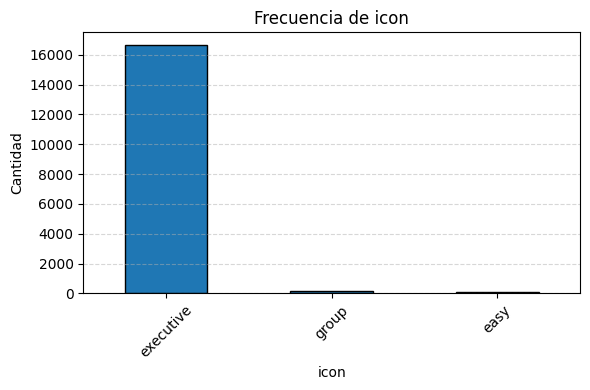

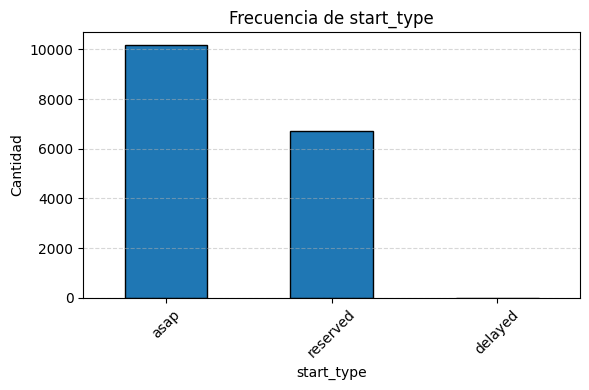

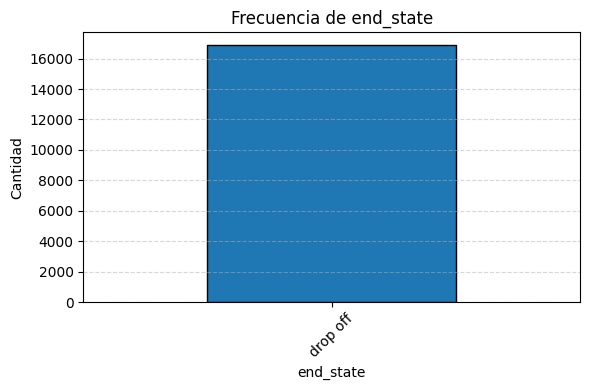

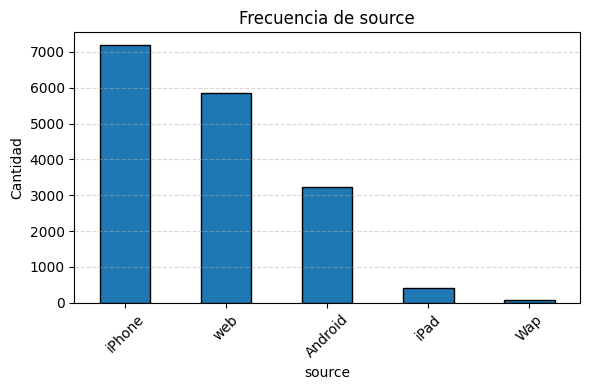

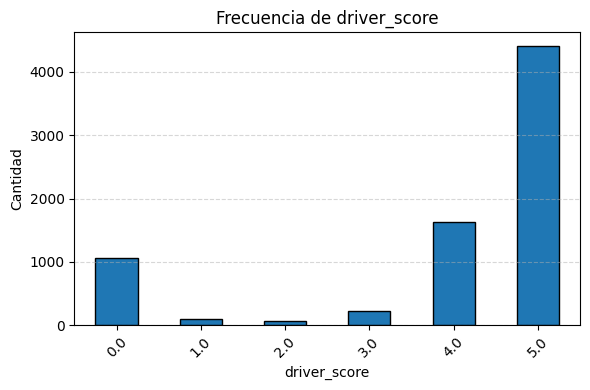

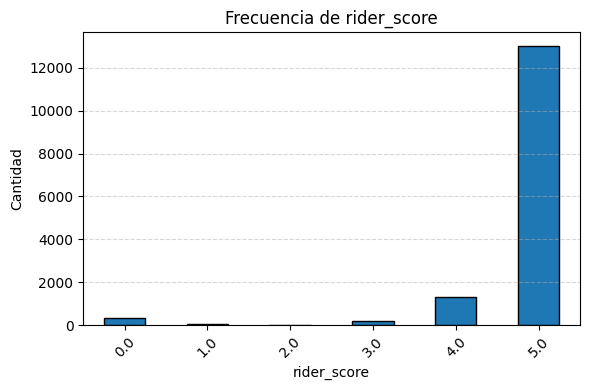

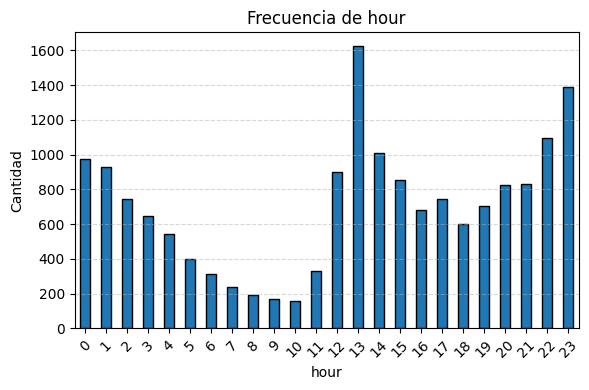

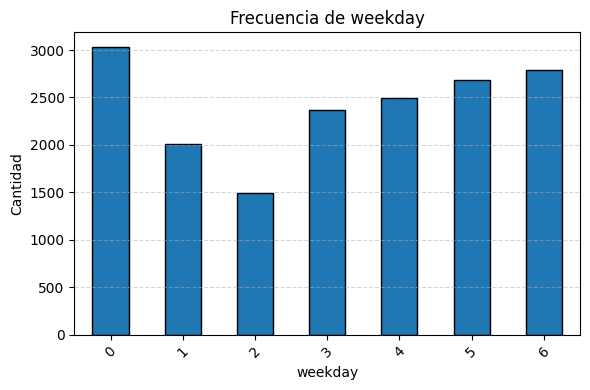

In [70]:
for col in cualitativas:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(df_drop[col]):
        # Ordenar valores únicos de menor a mayor
        orden = sorted(df_drop[col].dropna().unique())
        df_drop[col].value_counts().reindex(orden).plot(kind='bar', edgecolor='black')
    else:
        # Ordenar por frecuencia
        df_drop[col].value_counts().plot(kind='bar', edgecolor='black')

    plt.title(f'Frecuencia de {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [71]:
def detectar_distribucion(df, columnas):
    distribuciones = {
        "normal": stats.norm,
        "exponencial": stats.expon,
        "log-normal": stats.lognorm,
        "gamma": stats.gamma,
        "beta": stats.beta,
        "uniforme": stats.uniform,
        "weibull": stats.weibull_min,
        "chi-cuadrado": stats.chi2,
        "pareto": stats.pareto,
        "cauchy": stats.cauchy,
        "triangular": stats.triang,
        "logística": stats.logistic,
        "rayleigh": stats.rayleigh
    }

    resultados = {}

    for col in columnas:
        datos = df[col].dropna().values

        if len(datos) < 30:
            resultados[col] = "Muy pocos datos"
            continue

        mejores_pvalores = {}

        for nombre, distribucion in distribuciones.items():
            try:
                params = distribucion.fit(datos)
                D, p = stats.kstest(datos, distribucion.name, args=params)
                mejores_pvalores[nombre] = p
            except Exception as e:
                mejores_pvalores[nombre] = f"Error: {e}"

        mejores_pvalores_validos = {k: v for k, v in mejores_pvalores.items() if isinstance(v, float)}
        if mejores_pvalores_validos:
            mejor_distribucion = max(mejores_pvalores_validos, key=mejores_pvalores_validos.get)
            resultados[col] = {
                "mejor ajuste": mejor_distribucion,
                "p-valor": round(mejores_pvalores_validos[mejor_distribucion], 4)
            }
        else:
            resultados[col] = "No se pudo ajustar ninguna distribución"

    return resultados


In [72]:
resultado_distribuciones = detectar_distribucion(df_drop, cuantitativas)

for col, info in resultado_distribuciones.items():
    print(f"{col}: {info}")

c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\si

price: {'mejor ajuste': 'normal', 'p-valor': 0.0}
dist_driver_to_start_m: {'mejor ajuste': 'exponencial', 'p-valor': 0.0}
time_driver_to_start_s: {'mejor ajuste': 'rayleigh', 'p-valor': 0.0}
dist_start_to_end_m: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
time_start_to_end_s: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
wait_calc: {'mejor ajuste': 'rayleigh', 'p-valor': 0.0}
trip_calc: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
d2m: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
t2m: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
u10: {'mejor ajuste': 'log-normal', 'p-valor': 0.0001}
v10: {'mejor ajuste': 'chi-cuadrado', 'p-valor': 0.0466}
tcc: {'mejor ajuste': 'beta', 'p-valor': 0.0}
tp: {'mejor ajuste': 'beta', 'p-valor': 0.054}


In [73]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Contar frecuencias y tomar las 2 categorías más frecuentes
top2_cats = df_drop['start_type'].value_counts().nlargest(2).index.tolist()

grupo1 = df_drop[df_drop['start_type'] == top2_cats[0]]['price'].dropna()
grupo2 = df_drop[df_drop['start_type'] == top2_cats[1]]['price'].dropna()

print(f"Comparando categorías: '{top2_cats[0]}' vs '{top2_cats[1]}'")

# Test de normalidad Shapiro-Wilk
p_shapiro_g1 = shapiro(grupo1).pvalue
p_shapiro_g2 = shapiro(grupo2).pvalue

print(f"Shapiro-Wilk p-valor grupo '{top2_cats[0]}': {p_shapiro_g1:.4f}")
print(f"Shapiro-Wilk p-valor grupo '{top2_cats[1]}': {p_shapiro_g2:.4f}")

# Test de homogeneidad de varianzas Levene
p_levene = levene(grupo1, grupo2).pvalue
print(f"Levene p-valor (igualdad de varianzas): {p_levene:.4f}")

if p_shapiro_g1 > 0.05 and p_shapiro_g2 > 0.05:
    # Normalidad aceptada
    if p_levene > 0.05:
        stat, p = ttest_ind(grupo1, grupo2, equal_var=True)
        print("Usamos Test t para muestras independientes (varianzas iguales).")
    else:
        stat, p = ttest_ind(grupo1, grupo2, equal_var=False)
        print("Usamos Test t de Welch (varianzas diferentes).")
else:
    stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
    print("No se cumple normalidad, usamos Test Mann-Whitney.")

print(f"Estadístico = {stat:.4f}, p-valor = {p:.4f}")

if p < 0.05:
    print("➡️ Diferencia significativa en price entre grupos de start_type.")
else:
    print("➡️ No hay diferencia significativa en price entre grupos de start_type.")


Comparando categorías: 'asap' vs 'reserved'
Shapiro-Wilk p-valor grupo 'asap': 0.0000
Shapiro-Wilk p-valor grupo 'reserved': 0.0000
Levene p-valor (igualdad de varianzas): 0.0000
No se cumple normalidad, usamos Test Mann-Whitney.
Estadístico = 20752253.0000, p-valor = 0.0000
➡️ Diferencia significativa en price entre grupos de start_type.


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9609.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6029.
  res = hypotest_fun_out(*samples, **kwds)


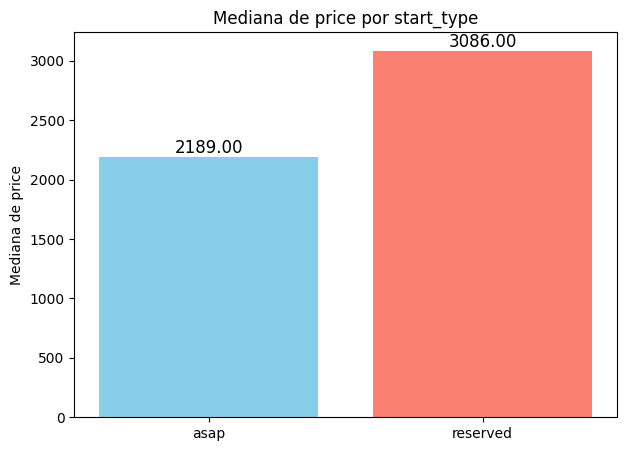

In [74]:
medianas = [grupo1.median(), grupo2.median()]
categorias = [top2_cats[0], top2_cats[1]]

plt.figure(figsize=(7,5))
bars = plt.bar(categorias, medianas, color=['skyblue', 'salmon'])
plt.ylabel('Mediana de price')
plt.title('Mediana de price por start_type')

# Agregar etiquetas con el valor de la mediana arriba de cada barra
for bar, med in zip(bars, medianas):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{med:.2f}',
             ha='center', va='bottom', fontsize=12)

plt.show()


--- Análisis para variable: icon ---
P-valores test normalidad Shapiro-Wilk:
  easy: p-valor = 9.4579e-04
  executive: p-valor = 1.9120e-85
  group: p-valor = 2.8982e-02
Kruskal-Wallis: estadístico=26.6955, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
               easy  executive     group
easy       1.000000   0.294317  0.022478
executive  0.294317   1.000000  0.000003
group      0.022478   0.000003  1.000000


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15594.
  res = hypotest_fun_out(*samples, **kwds)


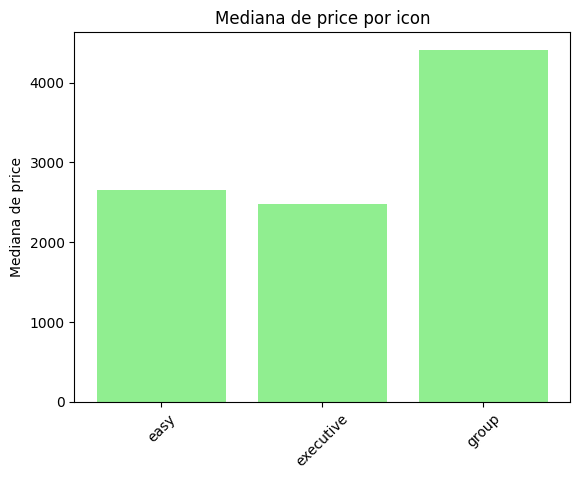


--- Análisis para variable: start_type ---
P-valores test normalidad Shapiro-Wilk:
  asap: p-valor = 2.0211e-78
  delayed: p-valor = 4.0966e-01
  reserved: p-valor = 1.5788e-55
Kruskal-Wallis: estadístico=918.0805, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
                   asap   delayed       reserved
asap       1.000000e+00  0.535026  5.493398e-201
delayed    5.350259e-01  1.000000   1.000000e+00
reserved  5.493398e-201  1.000000   1.000000e+00


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9609.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6029.
  res = hypotest_fun_out(*samples, **kwds)


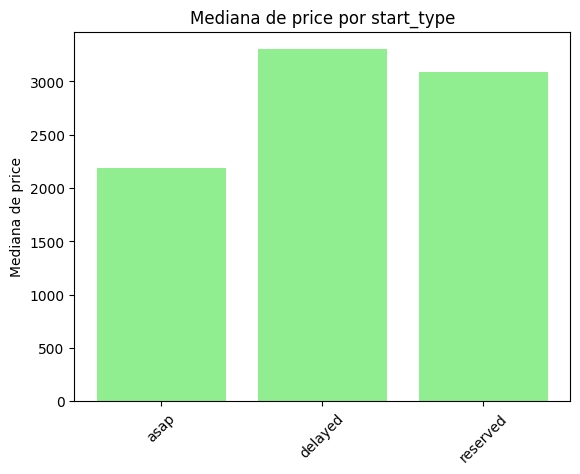


--- Análisis para variable: source ---
P-valores test normalidad Shapiro-Wilk:
  Android: p-valor = 2.4582e-51
  Wap: p-valor = 1.2155e-08
  iPad: p-valor = 4.0456e-13
  iPhone: p-valor = 5.3679e-68
  web: p-valor = 2.0059e-60
Kruskal-Wallis: estadístico=67.7497, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              Android       Wap          iPad        iPhone           web
Android  1.000000e+00  1.000000  3.278161e-13  1.000000e+00  6.629277e-03
Wap      1.000000e+00  1.000000  7.071326e-03  1.000000e+00  1.000000e+00
iPad     3.278161e-13  0.007071  1.000000e+00  8.811580e-13  3.862491e-09
iPhone   1.000000e+00  1.000000  8.811580e-13  1.000000e+00  1.696399e-02
web      6.629277e-03  1.000000  3.862491e-09  1.696399e-02  1.000000e+00


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6904.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5161.
  res = hypotest_fun_out(*samples, **kwds)


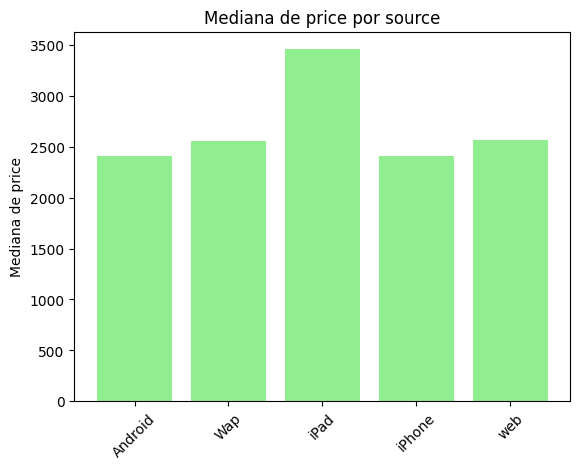


--- Análisis para variable: driver_score ---
P-valores test normalidad Shapiro-Wilk:
  0.0: p-valor = 1.8532e-35
  1.0: p-valor = 3.2236e-06
  2.0: p-valor = 3.5322e-06
  3.0: p-valor = 7.2984e-15
  4.0: p-valor = 7.2239e-42
  5.0: p-valor = 9.1982e-59
Kruskal-Wallis: estadístico=25.9261, p-valor=0.0001
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
          0.0       1.0  2.0       3.0       4.0       5.0
0.0  1.000000  0.002930  1.0  0.016634  1.000000  1.000000
1.0  0.002930  1.000000  1.0  1.000000  0.004856  0.008748
2.0  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
3.0  0.016634  1.000000  1.0  1.000000  0.030452  0.063262
4.0  1.000000  0.004856  1.0  0.030452  1.000000  1.000000
5.0  1.000000  0.008748  1.0  0.063262  1.000000  1.000000


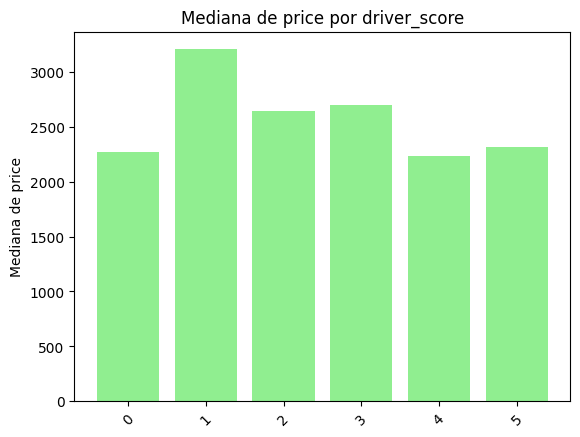


--- Análisis para variable: rider_score ---
P-valores test normalidad Shapiro-Wilk:
  0.0: p-valor = 5.2036e-20
  1.0: p-valor = 1.1545e-06
  2.0: p-valor = 1.0132e-05
  3.0: p-valor = 8.7561e-18
  4.0: p-valor = 9.8273e-36
  5.0: p-valor = 2.2300e-80
Kruskal-Wallis: estadístico=29.3140, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
          0.0       1.0  2.0       3.0       4.0       5.0
0.0  1.000000  1.000000  1.0  1.000000  0.180700  0.513251
1.0  1.000000  1.000000  1.0  1.000000  0.465109  0.709026
2.0  1.000000  1.000000  1.0  1.000000  1.000000  1.000000
3.0  1.000000  1.000000  1.0  1.000000  0.000255  0.000731
4.0  0.180700  0.465109  1.0  0.000255  1.000000  1.000000
5.0  0.513251  0.709026  1.0  0.000731  1.000000  1.000000


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12317.
  res = hypotest_fun_out(*samples, **kwds)


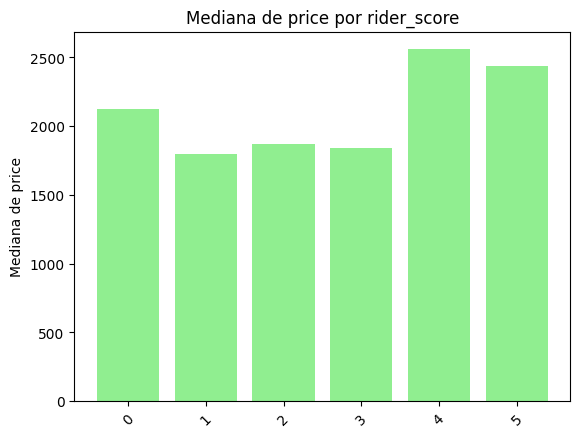


--- Análisis para variable: hour ---
P-valores test normalidad Shapiro-Wilk:
  0: p-valor = 8.8529e-32
  1: p-valor = 1.1254e-28
  2: p-valor = 2.2816e-26
  3: p-valor = 1.3925e-22
  4: p-valor = 1.1261e-22
  5: p-valor = 2.2916e-20
  6: p-valor = 1.8039e-17
  7: p-valor = 7.4281e-15
  8: p-valor = 3.3885e-09
  9: p-valor = 8.9644e-07
  10: p-valor = 3.4343e-05
  11: p-valor = 1.1245e-09
  12: p-valor = 2.8735e-28
  13: p-valor = 4.1295e-43
  14: p-valor = 7.4300e-34
  15: p-valor = 2.4028e-30
  16: p-valor = 4.3352e-28
  17: p-valor = 7.3650e-30
  18: p-valor = 6.4502e-25
  19: p-valor = 7.6615e-28
  20: p-valor = 2.0203e-31
  21: p-valor = 4.8663e-28
  22: p-valor = 4.0987e-33
  23: p-valor = 4.6726e-37
Kruskal-Wallis: estadístico=598.6637, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              0             1             2             3             4   \
0   1.000000e+00  1.000000e+00  1.000000e+00  1.0663

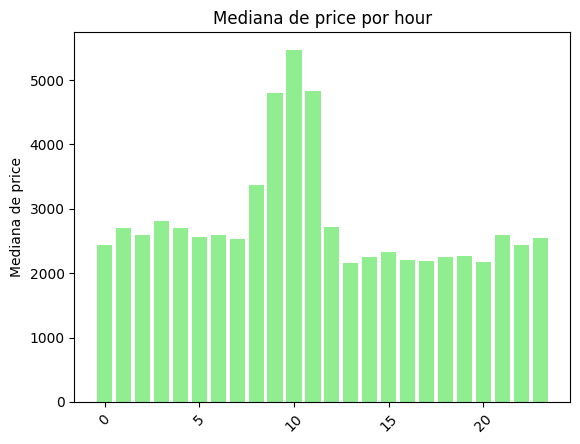


--- Análisis para variable: weekday ---
P-valores test normalidad Shapiro-Wilk:
  0: p-valor = 6.7733e-50
  1: p-valor = 9.5936e-39
  2: p-valor = 1.9095e-32
  3: p-valor = 5.3384e-46
  4: p-valor = 1.6843e-47
  5: p-valor = 1.0518e-49
  6: p-valor = 6.9981e-48
Kruskal-Wallis: estadístico=133.1108, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              0             1             2             3             4  \
0  1.000000e+00  3.933231e-05  9.925457e-09  1.000000e+00  2.468173e-01   
1  3.933231e-05  1.000000e+00  1.000000e+00  4.634908e-06  1.573191e-10   
2  9.925457e-09  1.000000e+00  1.000000e+00  1.113756e-09  1.174335e-14   
3  1.000000e+00  4.634908e-06  1.113756e-09  1.000000e+00  1.000000e+00   
4  2.468173e-01  1.573191e-10  1.174335e-14  1.000000e+00  1.000000e+00   
5  6.457867e-03  6.182058e-14  2.738786e-18  1.620255e-01  1.000000e+00   
6  1.000000e+00  7.109082e-06  1.497828e-09  1.000000e+0

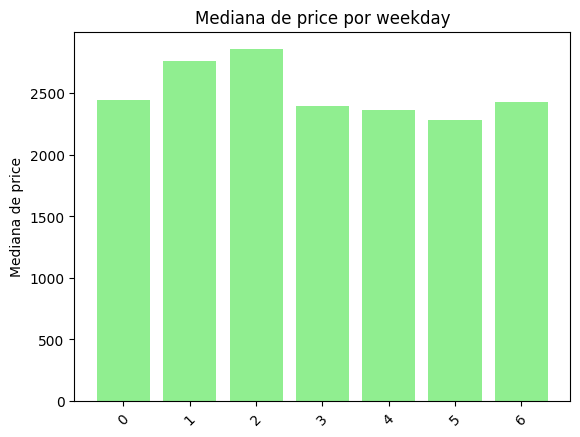

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, f_oneway, kruskal
import scikit_posthocs as sp

# Lo que hace este test basicamente es hacer un anova (pero no literlamente porque no acepta distribucion normal) Es por eso que se usa la mediana (Se podria borrar Dunnet y Los test para la normalidad)

def analizar_cualitativas(df, target_col, cualitativas): # Lo que hace este test basicamente es hacer un anova (pero no literlamente porque no acepta distribucion normal)
    for var in cualitativas:
        print(f"\n--- Análisis para variable: {var} ---")
        grupos = sorted(df[var].dropna().unique())
        datos_por_grupo = [df[df[var] == g][target_col].dropna() for g in grupos]

        # Test de normalidad Shapiro-Wilk por grupo
        normalidad_ok = True
        print("P-valores test normalidad Shapiro-Wilk:")
        for g, datos in zip(grupos, datos_por_grupo):
            if len(datos) < 3:
                print(f"  {g}: Muy pocos datos para test")
                continue
            p_val = shapiro(datos).pvalue
            print(f"  {g}: p-valor = {p_val:.4e}")
            if p_val < 0.05:
                normalidad_ok = False

        if normalidad_ok:
            # Test homogeneidad de varianzas
            p_levene = levene(*datos_por_grupo).pvalue
            print(f"Levene p-valor: {p_levene:.4f}")
            if p_levene > 0.05:
                stat, p = f_oneway(*datos_por_grupo)
                print(f"ANOVA: estadístico={stat:.4f}, p-valor={p:.4f}")
                if p < 0.05:
                    print("➡️ Diferencias significativas entre grupos (ANOVA).")
                else:
                    print("➡️ No diferencias significativas entre grupos (ANOVA).")
                # Gráfico con medias
                medias = [np.mean(datos) for datos in datos_por_grupo]
                plt.bar(grupos, medias, color='skyblue')
                plt.ylabel(f'Media de {target_col}')
                plt.title(f'Media de {target_col} por {var}')
                plt.xticks(rotation=45)
                plt.show()
            else:
                print("Varianzas no homogéneas, se recomienda Welch ANOVA.")
        else:
            # Test no paramétrico Kruskal-Wallis
            stat, p = kruskal(*datos_por_grupo)
            print(f"Kruskal-Wallis: estadístico={stat:.4f}, p-valor={p:.4f}")
            if p < 0.05:
                print("➡️ Diferencias significativas entre grupos (Kruskal-Wallis).")
                # Post-hoc Dunn
                print("Test post-hoc Dunn (ajustado Bonferroni):")
                data = df[[var, target_col]].dropna()
                dunn_res = sp.posthoc_dunn(data, val_col=target_col, group_col=var, p_adjust='bonferroni')
                print(dunn_res)
            else:
                print("➡️ No diferencias significativas entre grupos (Kruskal-Wallis).")
            # Gráfico con medianas
            medianas = [np.median(datos) for datos in datos_por_grupo]
            plt.bar(grupos, medianas, color='lightgreen')
            plt.ylabel(f'Mediana de {target_col}')
            plt.title(f'Mediana de {target_col} por {var}')
            plt.xticks(rotation=45)
            plt.show()

analizar_cualitativas(df_drop, 'price', ['icon','start_type','source','driver_score','rider_score','hour','weekday'])

In [76]:
import pandas as pd
from scipy.stats import chi2_contingency
from itertools import combinations

def test_dependencia_chi2_con_tabla(df, columnas_categoricas, alpha=0.05):
    resultados = []

    for var1, var2 in combinations(columnas_categoricas, 2):
        tabla = pd.crosstab(df[var1], df[var2])
        
        # Aplicamos el test chi2
        chi2, p, dof, expected = chi2_contingency(tabla)
        
        dependencia = "Dependiente" if p < alpha else "Independiente"
        
        resultados.append({
            'var1': var1,
            'var2': var2,
            'dependencia': dependencia,
            'p_valor': p,
            'tabla': tabla
        })

    return pd.DataFrame(resultados)

resultados_chi2 = test_dependencia_chi2_con_tabla(df_drop, cualitativas)
resultados_chi2 # Por si nos interesa ver alguna relacion de independencia de algunas de las variables cualis
# La tabla esta bueno para ver un caso mas visual (hay desglozarla para verla bien)

,var1,var2,dependencia,p_valor,tabla
0,icon,start_type,Dependiente,6.759249e-49,start_type asap delayed reserved icon ...
1,icon,end_state,Independiente,1.000000e+00,end_state drop off icon easy ...
2,icon,source,Dependiente,8.944006e-23,source Android Wap iPad iPhone web ic...
3,icon,driver_score,Dependiente,2.950687e-04,driver_score 0.0 1.0 2.0 3.0 4.0 5.0 ...
4,icon,rider_score,Dependiente,3.995486e-46,rider_score 0.0 1.0 2.0 3.0 4.0 5.0 i...
5,icon,hour,Dependiente,1.529725e-19,hour 0 1 2 3 4 5 6 ...
6,icon,weekday,Dependiente,1.183350e-05,weekday 0 1 2 3 4 5 ...
7,start_type,end_state,Independiente,1.000000e+00,end_state drop off start_type asap...
8,start_type,source,Dependiente,4.626705e-109,source Android Wap iPad iPhone web s...
9,start_type,driver_score,Dependiente,9.079949e-04,driver_score 0.0 1.0 2.0 3.0 4.0 5.0 s...


In [77]:
def post_hoc_todos(resultados_df, df_original, alpha=0.05):
    # Filtrar solo pares dependientes
    dependientes = resultados_df[resultados_df['dependencia'] == 'Dependiente'][['var1', 'var2', 'tabla']]

    for _, row in dependientes.iterrows():
        v1, v2 = row['var1'], row['var2']
        contingency = row['tabla']

        # Calcular tabla esperada (ya la calculaste antes, pero la recalculamos para asegurar)
        chi2, p, dof, expected = chi2_contingency(contingency, correction=False)

        # Residuales estandarizados
        residuals = (contingency - expected) / np.sqrt(expected)

        print(f"\n--- Post hoc entre '{v1}' y '{v2}' ---")
        print(f"Chi2 p-valor: {p:.4g}")

        # Mostrar celdas con residuos absolutos > 2
        mask = residuals.abs() > 2
        if mask.any().any():
            print("Celdas con dependencia fuerte (|residuo| > 2):")
            print(residuals[mask])
        else:
            print("No se detectaron celdas con residuos > 2.")

# Uso
post_hoc_todos(resultados_chi2, df_drop)



--- Post hoc entre 'icon' y 'start_type' ---
Chi2 p-valor: 6.759e-49
Celdas con dependencia fuerte (|residuo| > 2):
start_type      asap  delayed   reserved
icon                                    
easy       -4.869154      NaN   6.006952
executive        NaN      NaN        NaN
group      -8.176582      NaN  10.085571

--- Post hoc entre 'icon' y 'source' ---
Chi2 p-valor: 8.944e-23
Celdas con dependencia fuerte (|residuo| > 2):
source      Android  Wap      iPad    iPhone       web
icon                                                  
easy            NaN  NaN       NaN -6.171942  6.820637
executive       NaN  NaN       NaN       NaN       NaN
group     -2.558379  NaN  4.319696       NaN  2.454652

--- Post hoc entre 'icon' y 'driver_score' ---
Chi2 p-valor: 0.0002951
Celdas con dependencia fuerte (|residuo| > 2):
driver_score       0.0  1.0  2.0  3.0       4.0  5.0
icon                                                
easy          4.001070  NaN  NaN  NaN -2.065692  NaN
executive   

In [78]:
df_drop[cuantitativas].corr()

,price,dist_driver_to_start_m,time_driver_to_start_s,dist_start_to_end_m,time_start_to_end_s,wait_calc,trip_calc,d2m,t2m,u10,v10,tcc,tp
price,1.000000,0.203900,0.164095,0.827873,0.773196,0.147179,0.642472,-0.012980,-0.064846,-0.080691,-0.077431,0.028506,-0.027510
dist_driver_to_start_m,0.203900,1.000000,0.931101,0.218654,0.204993,0.881546,0.164935,-0.010963,-0.093953,-0.110800,-0.091631,0.039926,0.021284
time_driver_to_start_s,0.164095,0.931101,1.000000,0.164532,0.168176,0.951350,0.123645,-0.010410,-0.100894,-0.132351,-0.099163,0.038961,0.038963
dist_start_to_end_m,0.827873,0.218654,0.164532,1.000000,0.934168,0.142756,0.749913,-0.003246,-0.036237,-0.043196,-0.041316,0.022063,-0.056252
time_start_to_end_s,0.773196,0.204993,0.168176,0.934168,1.000000,0.146215,0.790116,0.003803,-0.030674,-0.050804,-0.050092,0.020246,-0.045569
wait_calc,0.147179,0.881546,0.951350,0.142756,0.146215,1.000000,0.111354,0.007410,-0.063512,-0.101167,-0.086929,0.032226,0.012527
trip_calc,0.642472,0.164935,0.123645,0.749913,0.790116,0.111354,1.000000,0.004242,-0.004414,-0.007879,-0.010254,0.023421,-0.091417
d2m,-0.012980,-0.010963,-0.010410,-0.003246,0.003803,0.007410,0.004242,1.000000,0.866751,-0.016369,-0.276068,0.297823,0.137093
t2m,-0.064846,-0.093953,-0.100894,-0.036237,-0.030674,-0.063512,-0.004414,0.866751,1.000000,0.281473,-0.088708,0.155220,-0.021726
u10,-0.080691,-0.110800,-0.132351,-0.043196,-0.050804,-0.101167,-0.007879,-0.016369,0.281473,1.000000,-0.081513,-0.065561,-0.208794


In [89]:
def probar_regresiones_significativas_filtrado(df, variables, excluir=[]):
    resultados = []
    n = len(variables)

    for i in range(n):
        for j in range(i + 1, n):  # Esto evita repeticiones y comparaciones con sí mismas
            x_name = variables[i]
            y_name = variables[j]

            # Excluir si alguna de las variables está en la lista de exclusión
            if x_name in excluir or y_name in excluir:
                continue

            df_xy = df[[x_name, y_name]].dropna()

            if df_xy.shape[0] < 10:
                continue

            x_vals = df_xy[x_name].values.reshape(-1, 1)
            y_vals = df_xy[y_name].values

            def guardar_resultado(tipo, pvalue, r2):
                if pvalue < 0.05:
                    resultados.append({
                        'Var 1': x_name,
                        'Var 2': y_name,
                        'Tipo_regresion': tipo,
                        'P-valor': round(pvalue, 4),
                        'R²': round(r2, 4)
                    })

            # Lineal
            modelo = LinearRegression().fit(x_vals, y_vals)
            pred = modelo.predict(x_vals)
            slope, intercept, r_value, p_value, std_err = linregress(x_vals.flatten(), y_vals)
            guardar_resultado('Lineal', p_value, r_value**2)

            # Cuadrática
            poly2 = PolynomialFeatures(degree=2)
            x_poly2 = poly2.fit_transform(x_vals)
            modelo2 = LinearRegression().fit(x_poly2, y_vals)
            r2_quad = modelo2.score(x_poly2, y_vals)
            p_value_quad = linregress(x_poly2[:, 1], y_vals).pvalue
            guardar_resultado('Cuadrática', p_value_quad, r2_quad)

            # Cúbica
            poly3 = PolynomialFeatures(degree=3)
            x_poly3 = poly3.fit_transform(x_vals)
            modelo3 = LinearRegression().fit(x_poly3, y_vals)
            r2_cubic = modelo3.score(x_poly3, y_vals)
            p_value_cubic = linregress(x_poly3[:, 1], y_vals).pvalue
            guardar_resultado('Cúbica', p_value_cubic, r2_cubic)

            # Logarítmica (x > 0)
            if np.all(x_vals > 0):
                x_log = np.log(x_vals)
                modelo_log = LinearRegression().fit(x_log, y_vals)
                r2_log = modelo_log.score(x_log, y_vals)
                p_value_log = linregress(x_log.flatten(), y_vals).pvalue
                guardar_resultado('Logarítmica', p_value_log, r2_log)

            # Exponencial (y > 0)
            if np.all(y_vals > 0):
                y_log = np.log(y_vals)
                modelo_exp = LinearRegression().fit(x_vals, y_log)
                r2_exp = modelo_exp.score(x_vals, y_log)
                p_value_exp = linregress(x_vals.flatten(), y_log).pvalue
                guardar_resultado('Exponencial', p_value_exp, r2_exp)

    return pd.DataFrame(resultados)

# Ejecución
variables_excluir = ['time_driver_to_start_s', 'time_start_to_end_s']
regresiones_filtradas = probar_regresiones_significativas_filtrado(df_drop, cuantitativas, excluir=variables_excluir)
regresiones_filtradas.loc[regresiones_filtradas['Var 1']=='price']




,Var 1,Var 2,Tipo_regresion,P-valor,R²
0,price,dist_driver_to_start_m,Lineal,0.0000,0.0416
1,price,dist_driver_to_start_m,Cuadrática,0.0000,0.0422
2,price,dist_driver_to_start_m,Cúbica,0.0000,0.0436
3,price,dist_driver_to_start_m,Logarítmica,0.0000,0.0426
4,price,dist_start_to_end_m,Lineal,0.0000,0.6854
5,price,dist_start_to_end_m,Cuadrática,0.0000,0.6854
6,price,dist_start_to_end_m,Cúbica,0.0000,0.6898
7,price,dist_start_to_end_m,Logarítmica,0.0000,0.6419
8,price,dist_start_to_end_m,Exponencial,0.0000,0.5423
9,price,wait_calc,Lineal,0.0000,0.0217
